In [6]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
from skimage import io as sio
from skimage.transform import resize
from scipy import io
from scipy.stats import mode
from pathlib import Path

from PIL import Image

import tensorflow as tf
import tensorflow.compat.v1.keras.backend as K
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
K.set_session(session)

from keras import layers
from keras import Model
from keras.optimizers import Adam
from keras.utils import to_categorical 
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet import ResNet50
from keras.applications.vgg19 import VGG19
from keras.models import model_from_json

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [ ]:
%%bash

find ADNI/ -type f -exec mv -i '{}' ADNI/ ';'

# Data Processing

* The **ADNI** project is made up of four phases (ADNI-1, ADNI-GO, ADNI-2, ADNI-3) that collected results from new participants and monitored existing participants from previous on-going phases. At each phase, a cohort was formed and monitored. Participants enrolled were between the ages of 55 and 90 and were recruited at 57 sites in the United States and Canada. ADNI provides a wide series of both image and tabular data of each visit of participants. Participants in ADNI are grouped into **3 clinical disease states**: (1) cognitively normal (**CN**); (2) Mild Cognitive Impairment (**MCI**); (3) Dementia (**AD**).

* MRI utilize strong magnetic fields and radio waves to generate images. By varying the parameters of the pulse sequence, different contrasts can be generated between tissues. TR and TE are basic pulse sequence parameters that stand for repetition time and echo time respectively. A short TR and short TE sequence is usually called T1-weighted whereas long TR and long TE sequence is usually called T2-weighted. T1 images highlights fatty tissues while T2 images highlights fatty AND water-based tissues. The field strength of the magnet is measured in teslas and the majority of systems operate at 1.5T (Bitar et al., 2006).

* In this project we particularly look at MRI data collected from **ADNI1**. The MRI protocol for ADNI1 (2004-2009) focused on consistent longitudinal structural imaging on **1.5T** scanners using T1-weighted sequences. The 3D images are acquired from sagittal plane and come with different sizes. Each MPRAGE image in ADNI1 have undergone specific image pre-processing correction steps. Specifically, we picked all pre- processed MRI scans with **GradWarp, B1 non-uniformity, N3 correction and Image Scaling**. To this end we subsetted a dataset of **3068** MRI scans where each scan represents a visit and one patient can have multiple visit throughout the phase. The data preprocessing pipeline of the data we acquired is demonstrated below:

![title](img/1.png)


## T1 Corrected Images

* There are two types of image shape for all 3068 T1 images, either $160\times 192\times 192$ or $196\times 256\times 256$. We decided to look at only one type of image shape, namely $160\times 192\times 192$, in order to be consistent with the image quality and we are left with **1400** images. The total size of the raw 1400 images is around 80GB.

In [3]:
data_dir = Path("../ADNI/")
images = list(data_dir.glob("*.nii"))
len(images)

1400

* When we look at the images, their are **two major issues** that could negatively influence the data modeling:

    1. **Inconsistency of spatial information across images**: that is, same slice in different images can corresponding to different locations
    2. **Skull not stripped**: skulls as well as the area around eyes and noses are not help with the prediction, and could bias the prediction results
   
   
* We can see these two issues from the visualization below:

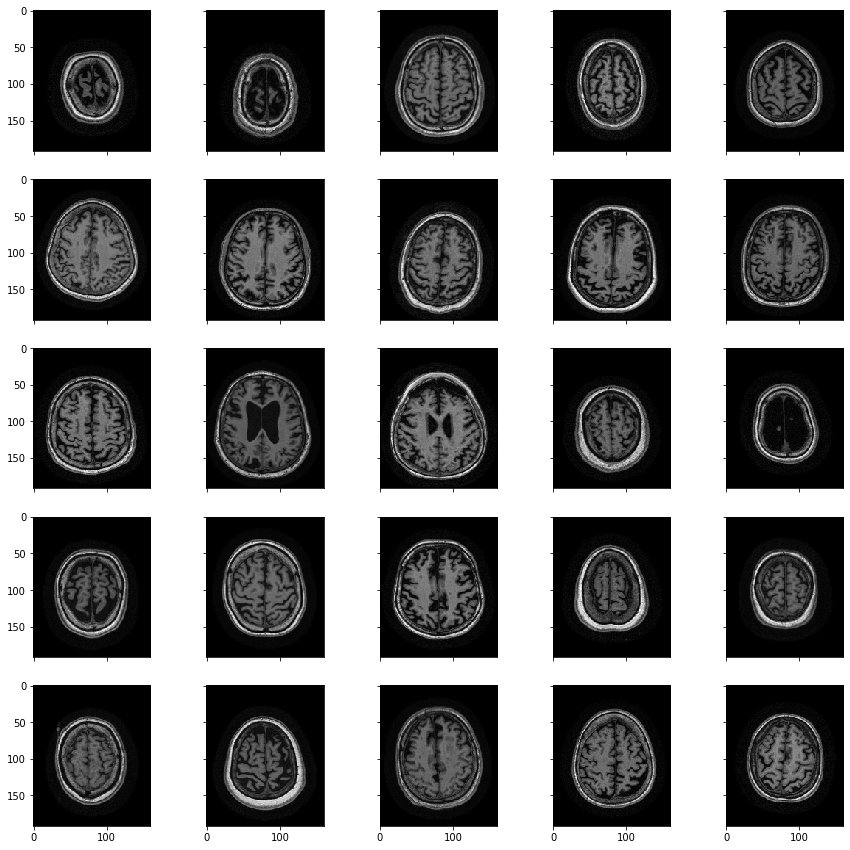

In [46]:
fig, ax = plt.subplots(5, 5, figsize=(15,15), sharex='col', sharey='row')
for i in range(5):
    for j in range(5):
        image = sio.imread(images[i * 5 + j])
        image0 = Image.fromarray(image[:,:,50])
        ax[i, j].imshow(np.transpose(image0), cmap=plt.get_cmap('gray'))

<center><b>Fig 1: </b>The 50th axiel slice of T1 MRI for different patients</center>

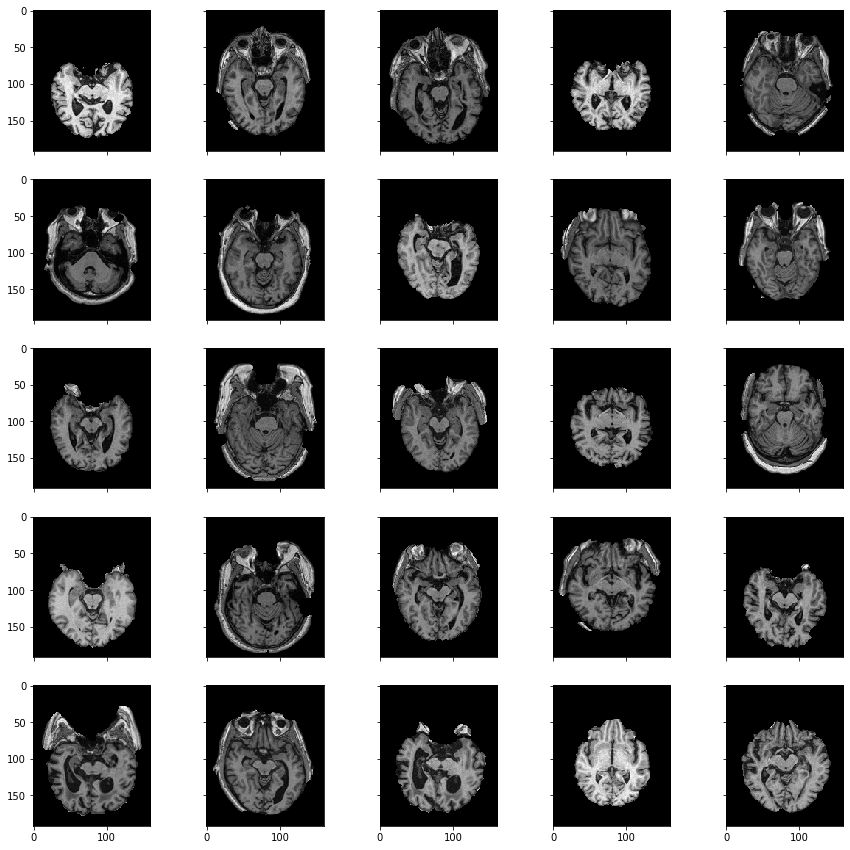

In [7]:
fig, ax = plt.subplots(5, 5, figsize=(15,15), sharex='col', sharey='row')
for i in range(5):
    for j in range(5):
        image = sio.imread(images[i * 5 + j])
        image0 = Image.fromarray(image[:,:,100])
        ax[i, j].imshow(np.transpose(image0), cmap=plt.get_cmap('gray'))

<center><b>Fig 2: </b>The 100th axiel slice of T1 MRI for different patients</center>

## FSL Processed Images

* One issue with our images is that ADNI T1 images contain non-brain related areas such as eyes, skulls, etc. that are irrelevant and can hurt classification. **FSL** is a software library containing image analysis and statistical tools for functional, structural and diffusion MRI brain imaging data. With FSL, we are able to achieve the following,

    1. FSL’s BET (Brain Extraction Tool) deletes non-brain tissue from an image of the whole head
    2. Estimate the inner and outer skull surfaces, and outer scalp surface, if you have good quality T1 and T2 input images.


### Skull stripped Images

* After applying FSL to our T1 images, we could see from the visualizations below that much of the skull has been removed. The software does well in skull stripping of the upper brain, but not very well for the lower part of the brain (close to eyes and noses) as demonstrated in Fig 4. So the presence of partially removed skull could still be an issue.

In [3]:
# FSL Processed Images
data_dir = Path("../ADNI/struc/")
images = list(data_dir.glob("*.nii"))
len(images)

1400

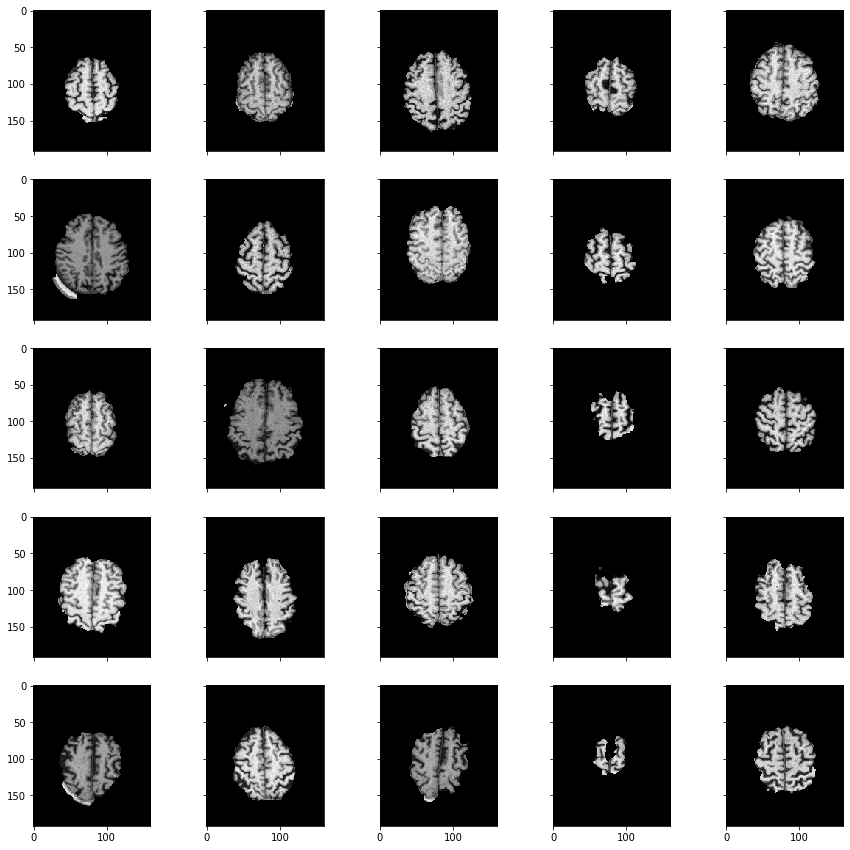

In [49]:
fig, ax = plt.subplots(5, 5, figsize=(15,15), sharex='col', sharey='row')
for i in range(5):
    for j in range(5):
        image = sio.imread(images[i * 5 + j])
        image0 = Image.fromarray(image[:,:,50])
        ax[i, j].imshow(np.transpose(image0), cmap=plt.get_cmap('gray'))

<center><b>Fig 3: </b>The 50th axiel slice of FSL Processed T1 MRI for different patients</center>

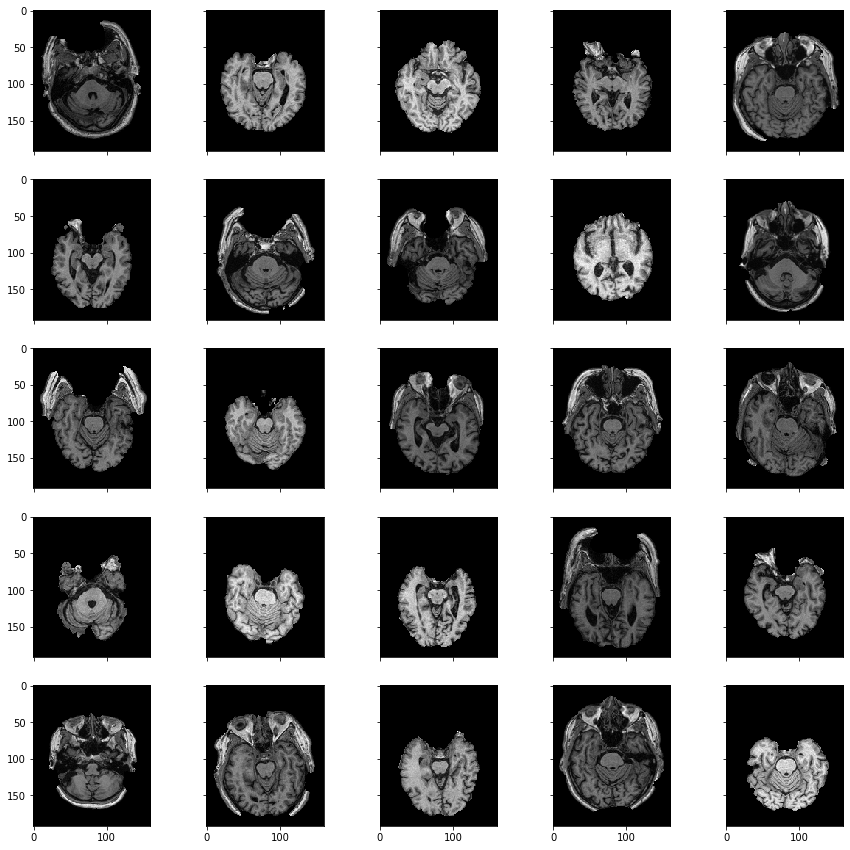

In [52]:
fig, ax = plt.subplots(5, 5, figsize=(15,15), sharex='col', sharey='row')
for i in range(5):
    for j in range(5):
        image = sio.imread(images[i * 5 + j + 30])
        image0 = Image.fromarray(image[:,:,110])
        ax[i, j].imshow(np.transpose(image0), cmap=plt.get_cmap('gray'))

<center><b>Fig 4: </b>The 100th axiel slice of FSL Processed T1 MRI for different patients</center>

### Pairwise comparison

* Below we show a pairwise comparison of the skull stripped VS original image of the same person, we see that much of the skull are removed.

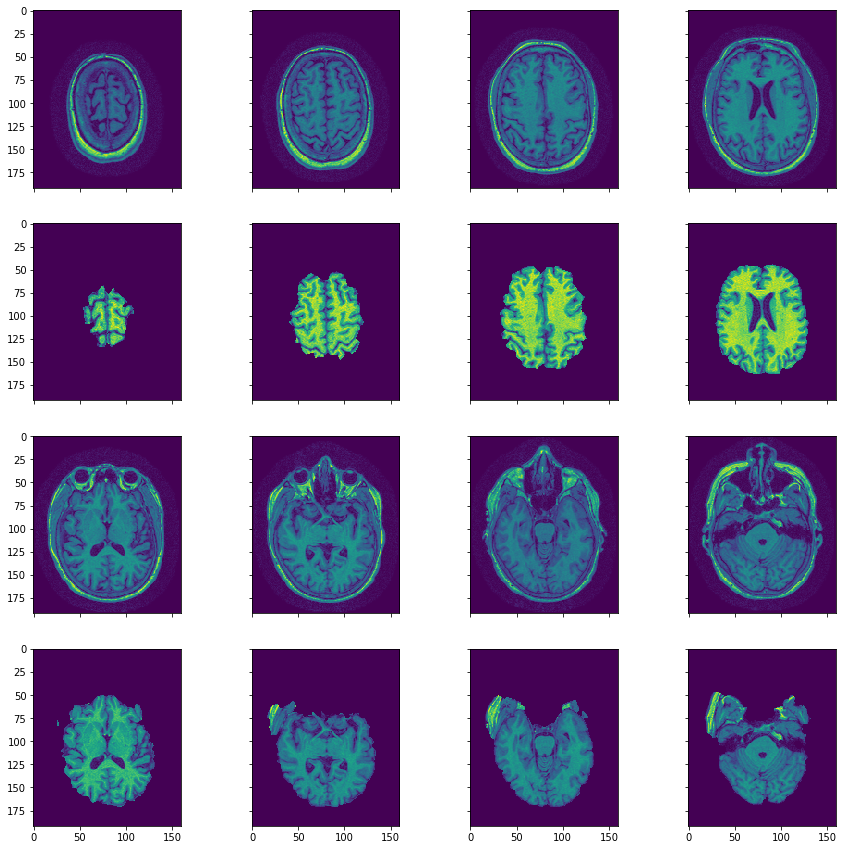

In [57]:
tmp = 'ADNI_003_S_1057_MR_MPR__GradWarp__B1_Correction__N3_Br_20080308121019979_S46176_I96201'
path_1 = '../ADNI/ADNI/' + tmp + '.nii'
path_2 = '../ADNI/struc/' + tmp + '_struc_brain.nii'

image_1 = sio.imread(path_1)
image_2 = sio.imread(path_2)

fig, ax = plt.subplots(4, 4, figsize=(15,15), sharex='col', sharey='row')
for i in [0,2]:
    for j in range(4):
        image1 = Image.fromarray(image_1[:,:,50+(i*2+j)*10])
        image2 = Image.fromarray(image_2[:,:,50+(i*2+j)*10])
        ax[i, j].imshow(np.transpose(image1))
        ax[i+1, j].imshow(np.transpose(image2))

<center><b>Fig 5: </b>Pairwise comparison of Orginal VS FSL Processed T1 MRI for patient id 003_S_1057</center>

## Spatial Normalization -- Starting Point Identification

* Another major issue for the images is **inconsistency of spatial information across images**. The ADNI image preprocessing and skull stripping by FSL guarantee that the brains to share similar size across patients, so the only issue remains is that the starting points of the brain are different across images. So to make sure that same slice in different images corresponding to the same locations, we need to identify the starting point of brain for each image.

### Method 1: Locate the first non-zero slice

* The FSL method does well in stripping the skull of the upper brain so one of the methods that we tried to identify the starting point of the brain is to find the first axiel slice with non-zero pixels. Fig 6 shows the histgram of the indices of first non-zero slice for each patient. We see that the range of the index of first non-zero slice is quite wide, so that this spatial normalization is necessary.

In [175]:
def first_nonzero(image, n):
    """
    Function return the number of first non-zero slice
    """
    return np.sum(np.sum(np.sum(np.transpose(image[:,:,0:n]), axis=2), axis=1) == 0) 

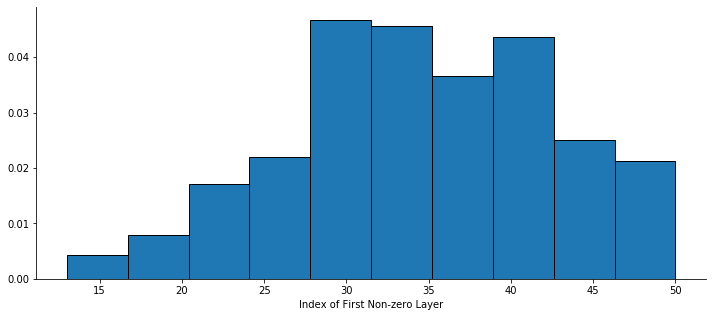

In [135]:
first = []
for image in images:
    tmp = sio.imread(image)
    first.append(first_nonzero(tmp, 50))
    
# initialize panel
f, ax = plt.subplots(figsize = (12,5))
# plot
ax.hist(first, density=True, edgecolor='black')
# disable top and right axes
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# labels and title
ax.axes.set_xlabel("Index of First Non-zero Layer")
ax.axes.set_ylabel("");

<center><b>Fig 6: </b>Histgram of the indices of first non-zero slice for each image</center>

* In Fig 7, we fixed the starting point for each image and showed the 60th slice after the starting point for each image. We see that each image shows approximately the same location for the same layer, but still we could see that there are considerable differences in terms of the brain location. Hence, we proposed a more robust method below.

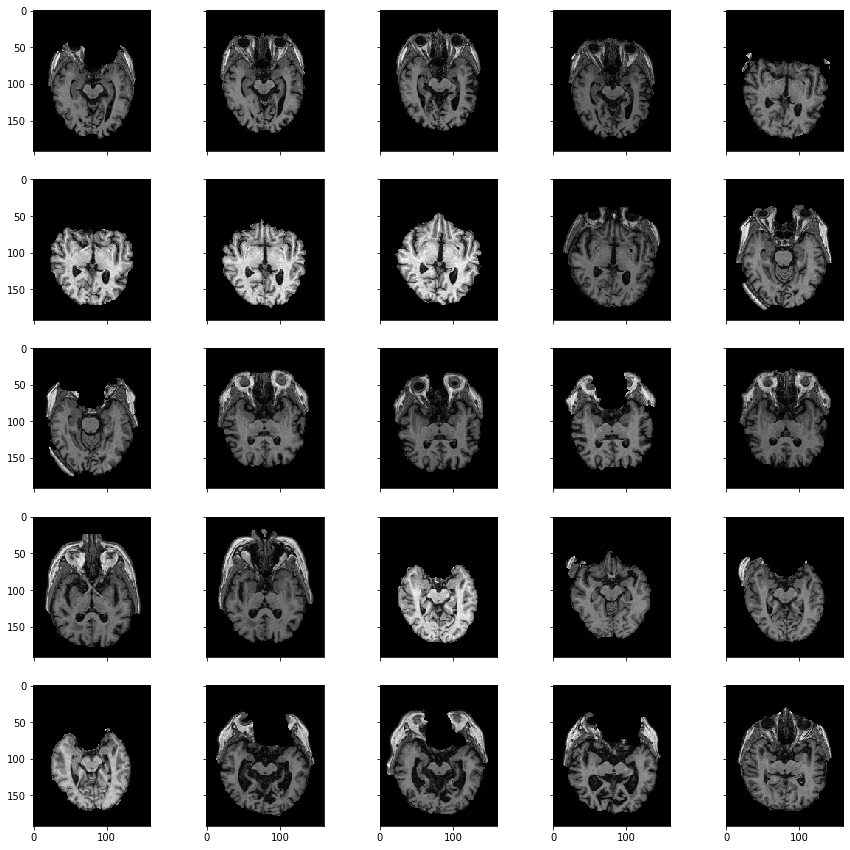

In [165]:
fig, ax = plt.subplots(5, 5, figsize=(15,15), sharex='col', sharey='row')
for i in range(5):
    for j in range(5):
        image = sio.imread(images[i * 5 + j])
        image0 = Image.fromarray(image[:,:,first[i * 5 + j] + 60])
        ax[i, j].imshow(np.transpose(image0), cmap=plt.get_cmap('gray'))

<center><b>Fig 7: </b>60th slice after the starting point for each image, starting point determined by method 1.</center>

### Method 2: Find a cutoff value for number of non-zero pixels in one layer

* The major issue of the method 1 is that the number of non-zero pixels in the first slice with non-zero pixels varies quite a lot, so even if we choose that slice as starting point, we could still end up with spatial inconsistency, To have a more robust method, we want to find a cutoff value for number of non-zero pixels in one layer, and use that number as the standard for selecting the starting point.

* We find the cutoff value by finding out the average number of non-zero pixels of the 5th Non-zero layer for every image.

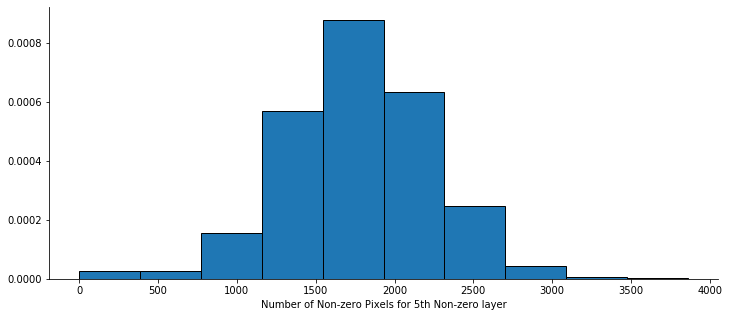

In [162]:
sum_5 = []
for i, image in enumerate(images):
    image = sio.imread(images[i])
    sum_5.append(len(np.nonzero(image[:,:,first[i] + 5])[0]))
    
# initialize panel
f, ax = plt.subplots(figsize = (12,5))
# plot
ax.hist(sum_5, density=True, edgecolor='black')
# disable top and right axes
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# labels and title
ax.axes.set_xlabel("Number of Non-zero Pixels for 5th Non-zero layer")
ax.axes.set_ylabel("");

<center><b>Fig 8: </b>Histogram of Number of Non-zero Pixels for 5th Non-zero layer</center>

* Below we find the index of slice with number of non-zero pixels closest to the cut-off value and use that as the starting point of the brain. In Fig 9, we fixed the starting point for each image by method 2 and showed the 60th slice after the starting point for each image. We see that the result is much better compared to method 1.

In [171]:
# mean of number of non-zero pixels of the 5th Non-zero layer for every image
np.mean(sum_5)

1770.9921428571429

In [172]:
np.std(sum_5)

474.0044265266272

In [181]:
def nonzero_cut(image, first, cutoff):
    """
    Function return the number of first non-zero slice
    """
    n = image.shape[2]
    i = first
    while i < n:
        if len(np.nonzero(image[:,:,i])[0]) >= cutoff:
            return i
        if i > 100:
            raise Exception('Value not found')
        i += 1

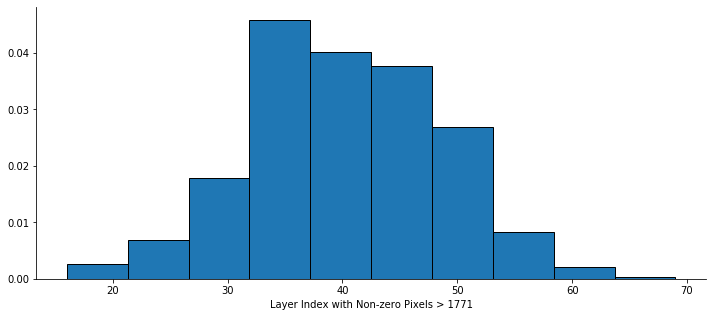

In [185]:
cut_5 = []
for i, image in enumerate(images):
    image = sio.imread(images[i])
    cut_5.append(nonzero_cut(image, first[i], 1771))
    
# initialize panel
f, ax = plt.subplots(figsize = (12,5))
# plot
ax.hist(cut_5, density=True, edgecolor='black')
# disable top and right axes
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# labels and title
ax.axes.set_xlabel("Layer Index with Non-zero Pixels > 1771")
ax.axes.set_ylabel("");

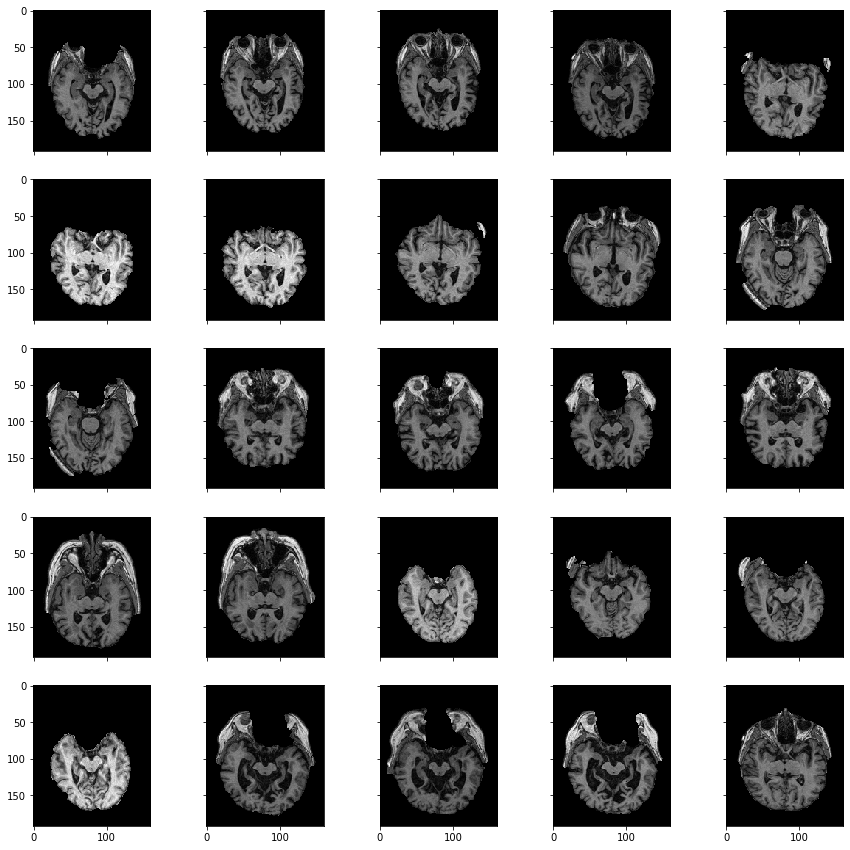

In [186]:
fig, ax = plt.subplots(5, 5, figsize=(15,15), sharex='col', sharey='row')
for i in range(5):
    for j in range(5):
        image = sio.imread(images[i * 5 + j])
        image0 = Image.fromarray(image[:,:,cut_5[i * 5 + j] + 55])
        ax[i, j].imshow(np.transpose(image0), cmap=plt.get_cmap('gray'))

<center><b>Fig 9: </b>60th slice after the starting point for each image, starting point determined by method 2.</center>

## Identify the Location of Hippocampus

* Since the whole brain contain a lot redundant information for AD classification and we don't want to put all those slices into CNN which could significantly slow down the training time. Since area around hippocampus has been demonstrated to be the most crutial area for AD classification, we've decided to specify the slices around hippocampus and only keep those slices for classification.

* We figured out the indices of slice where hippocampus locate by examining through a few samples.

### Visualizations

* In the following two figures, we visualized one CN sample and one AD sample and using red patches to circle out the hippocampus.

* Finally, the **30 hippocampus slices** that we use are from #(`cut_5` + 45) to #(`cut_5` + 75), where `cut_5` is the starting point for every image.

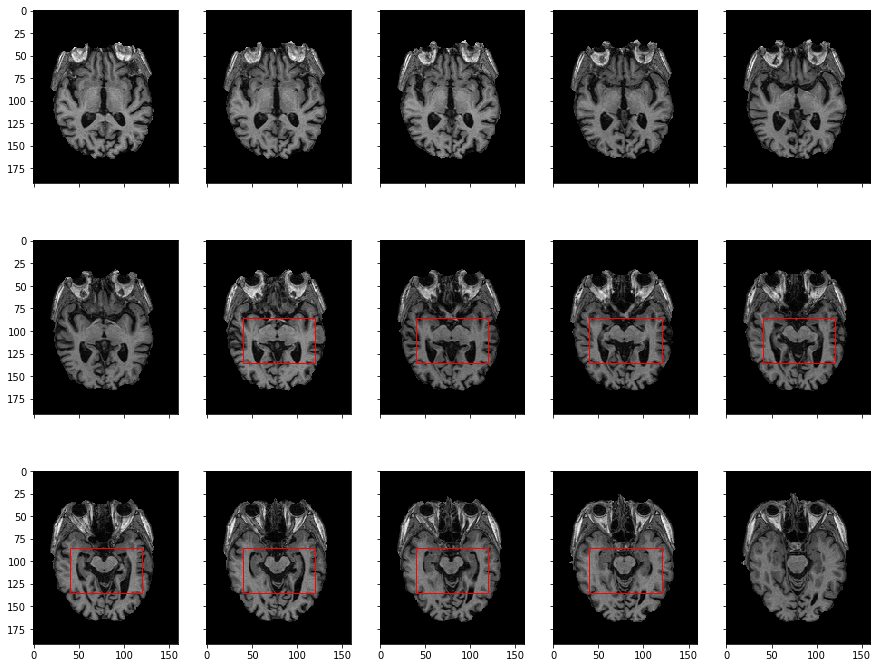

In [194]:
# CN
image = sio.imread(images[1])

fig, ax = plt.subplots(3, 5, figsize=(15,12), sharex='col', sharey='row')
for i in range(3):
    for j in range(5):
        ax[i,j].imshow(np.transpose(image[:,:,cut_5[1]+45+i*5+j]),cmap = plt.get_cmap('gray'))
        if i*5+j > 5 and i*5+j < 14:
            rect = patches.Rectangle((40,85), 80, 50,linewidth=1, edgecolor='r', facecolor='none')
            ax[i,j].add_patch(rect)

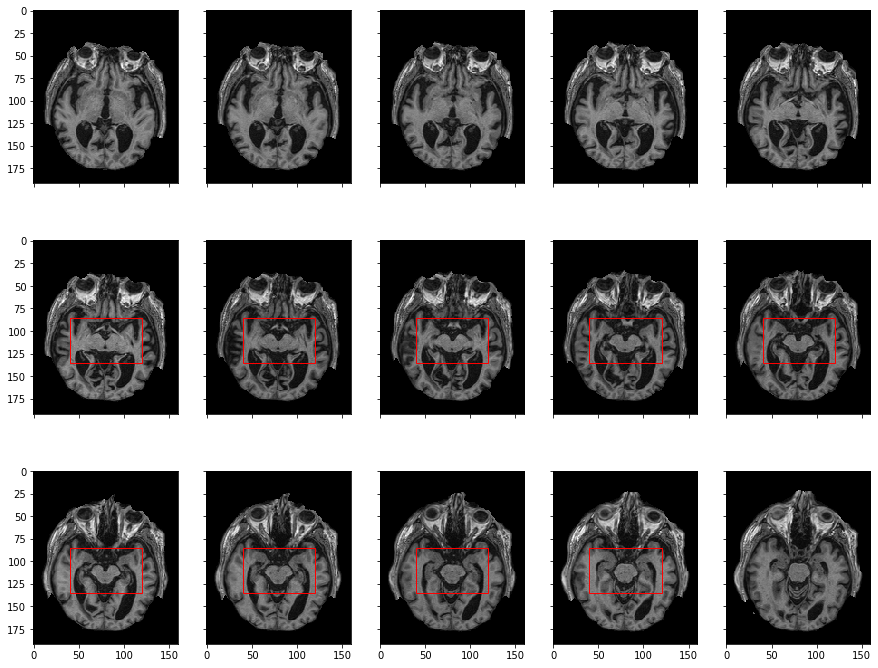

In [205]:
# AD
image = sio.imread(images[75])

fig, ax = plt.subplots(3, 5, figsize=(15,12), sharex='col', sharey='row')
for i in range(3):
    for j in range(5):
        ax[i,j].imshow(np.transpose(image[:,:,cut_5[75]+55+i*5+j]),cmap = plt.get_cmap('gray'))
        if i*5+j > 4 and i*5+j < 14:
            rect = patches.Rectangle((40,85), 80, 50,linewidth=1, edgecolor='r', facecolor='none')
            ax[i,j].add_patch(rect)

### Final Patch

* Since some of the image may have not fully removed skull which could interfere the prediction, we decided to choose only the brain area of these hippocampus slices, namely for each of the 30 slices, we cut out the middle brain area, which is from 30 to 130 in length and 70 to 170 in width. So the shape of the final patch for classification is $100 \times 100 \times 30$.

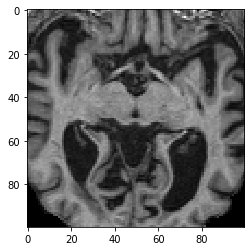

In [213]:
X = []
for i, image in enumerate(images):
    tmp = sio.imread(image)
    X.append(tmp[30:130, 70:170, (cut_5[i]+45):(cut_5[i]+75)])
X = np.array(X)

plt.imshow(np.transpose(image[30:130,70:170,cut_5[75]+60]),cmap = plt.get_cmap('gray'));

## Match Labels

* The code below match the label for each image.

In [127]:
data_dir = Path("../ADNI/struc/")
images = list(data_dir.glob("*.nii"))
images.sort()

# create a data frame for every visit
pid  = []
date = []

for image in images:
    pid.append(str(image)[19:29])
    date.append(str(image)[69:77])
    
ADNI_info = pd.DataFrame({'pid':pid, 'date':pd.to_datetime(date, format="%Y%m%d")})
ADNI_info['Year'] = ADNI_info.date.apply(lambda x: x.year)

# get the diagnosis from adnimerge data
adni_merge = pd.read_csv("ADNIMERGE.csv", low_memory=False)
adni_merge = adni_merge[['PTID', 'DX', 'EXAMDATE']]
adni_merge['EXAMDATE'] = pd.to_datetime(adni_merge.EXAMDATE, format="%Y-%m-%d")
adni_merge['Year'] = adni_merge.EXAMDATE.apply(lambda x: x.year)

In [ ]:
def returnDX(series):
    uni = series.unique()
    if 'Dementia' in uni:
        return 'Dementia'
    elif 'MCI' in uni:
        return 'MCI'
    elif 'CN' in uni:
        return 'CN'
    else:
        return np.nan

In [126]:
adni_DX = adni_merge.groupby(['PTID', 'Year']).agg({'DX': returnDX}).reset_index()
adni_DX = adni_DX.merge(adni_merge.groupby(['PTID']).agg({'DX': returnDX}).reset_index(),
                        how='left', left_on=['PTID'], right_on=['PTID'])
adni_DX['DX_x'] = adni_DX.DX_x.fillna(adni_DX['DX_y'])

ADNI_info = ADNI_info.merge(adni_DX, how='left', left_on=['pid', 'Year'], right_on=['PTID', 'Year'])

p_data = pd.read_csv("ADNI1_4_11_2020.csv")
p_data['date'] = pd.to_datetime(p_data['Acq Date'], format='%m/%d/%Y')
p_data = p_data.groupby(['Subject']).first().reset_index()[['Subject', 'Group']]
p_data.head()

Subject Group
0  002_S_0295    CN
1  002_S_0413    CN
2  002_S_0559    CN
3  002_S_0619    AD
4  002_S_0685    CN

* **For this data set, we end up with a total number of 1400 images, with 451 AD, 408 CN and 541 MCI.**

In [132]:
ADNI_info = ADNI_info.merge(p_data, how='left', left_on=['pid'], right_on=['Subject'])
ADNI_info['DX_x'] = ADNI_info.DX_x.fillna(ADNI_info['Group'])
y = np.array(ADNI_info['DX_x'].map({'Dementia':'AD', 'MCI':'MCI', 'CN':'CN', 'AD':'AD'}))
ADNI_info.to_csv('ADNI_info.csv')

np.unique(y, return_counts=True)

(array(['AD', 'CN', 'MCI'], dtype=object), array([451, 408, 541]))

In [215]:
y = np.array(ADNI_info['DX_x'].map({'Dementia':2, 'AD':2, 'MCI':1, 'CN':0}))
y = to_categorical(y).astype(np.integer)

io.savemat("ADNI_new.mat", {'y' : y, 'X' : X, 'first': np.array(cut_5)})

# AD Classification with CNN

* The hyperparameters are set as follows:
    
    1. Convolution kernel: Here we are constructing only 2D CNN;
    1. Loss function: for classification we choose `categorical_crossentropy`;
    2. Optimizer: We choose `Adam` as the optimizer, which has been demonstrated to outperform Stochastic Gradient Descent;
    3. Activation function: `ReLU` is used except for the last output layer which uses `softmax`;
    3. Batch size: For the model to run, we set a relative small batch size of 50-100;
    4. Data are split into Training, Validation and Testing which a ratio of 8:2:2.
    5. Learning rate (step size): We tried a series `lr` from 1e-2 to 1e-5 and select the one with higher validation accuracy.

## Benchmark Model : VGG19

* We first tried building models with existing popular CNN structures (VGG and ResNet)
* In the follwing model, we tried training VGG19 with input shape $100 \times 100 \times 30$. There is not pre-trained weights for input with 30 channels.

In [ ]:
ADNI = io.loadmat("ADNI_new.mat")
X, y = ADNI['X'], ADNI['y']
X = X / np.max(X)
X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
IMSIZE = 100
input_layer = layers.Input([IMSIZE, IMSIZE, 30])

# Block 1
x = layers.Conv2D(64, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block1_conv1')(input_layer)
x = layers.Conv2D(64, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block1_conv2')(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

# Block 2
x = layers.Conv2D(128, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block2_conv1')(x)
x = layers.Conv2D(128, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block2_conv2')(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

# Block 3
x = layers.Conv2D(256, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block3_conv1')(x)
x = layers.Conv2D(256, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block3_conv2')(x)
x = layers.Conv2D(256, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block3_conv3')(x)
x = layers.Conv2D(256, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block3_conv4')(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

# Block 4
x = layers.Conv2D(512, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block4_conv1')(x)
x = layers.Conv2D(512, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block4_conv2')(x)
x = layers.Conv2D(512, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block4_conv3')(x)
x = layers.Conv2D(512, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block4_conv4')(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

# Block 5
x = layers.Conv2D(512, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block5_conv1')(x)
x = layers.Conv2D(512, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block5_conv2')(x)
x = layers.Conv2D(512, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block5_conv3')(x)
x = layers.Conv2D(512, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block5_conv4')(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

x = layers.Flatten(name='flatten')(x)
x = layers.Dense(4096, activation='relu', name='fc1')(x)
x = layers.Dense(4096, activation='relu', name='fc2')(x)
x = layers.Dense(3, activation='softmax', name='predictions')(x)
output_layer = x

model = Model(input_layer,output_layer)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 30)      0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      17344     
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0   

In [10]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.01),
              metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=50, 
          epochs=50, validation_split=0.2)

y_test_pred = model.predict(X_test)

# print test accuracy
np.mean(np.argmax(y_test, axis=1) == np.argmax(y_test_pred, axis=1))

0.5892857142857143


* We see that the test accuracy is mediocre. We also tried ResNet with no pretrained weights and the result is also not good. In this sense, we suspect that very deep networks are not suitable for AD classification and we next tried several shallow networks.

## Shallow VGG

* Here we proposed a shallow CNN structure which is similar to VGG but with only 3 blocks and less convolution kernels in each block. We trained 75 epoches on this model and achieved a 69.3\% accuracy.

In [11]:
IMSIZE = 100
input_layer = layers.Input([IMSIZE, IMSIZE, 30])

# Block 1
x = layers.Conv2D(32, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block1_conv1')(input_layer)
x = layers.Conv2D(32, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block1_conv2')(x)
x = layers.MaxPooling2D((3, 3), strides=(3, 3), name='block1_pool')(x)

# Block 2
x = layers.Conv2D(64, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block2_conv1')(x)
x = layers.Conv2D(64, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block2_conv2')(x)
x = layers.MaxPooling2D((5, 5), strides=(3, 3), name='block2_pool')(x)
x = layers.BatchNormalization()(x)

# Block 3
x = layers.Conv2D(128, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block3_conv1')(x)
x = layers.Conv2D(128, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block3_conv2')(x)
x = layers.Conv2D(128, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block3_conv3')(x)
x = layers.MaxPooling2D((3, 3), strides=(3, 3), name='block3_pool')(x)
x = layers.BatchNormalization()(x)

x = layers.Flatten(name='flatten')(x)
#x = layers.Dense(512, activation='relu', name='fc1')(x)
x = layers.Dense(3, activation='softmax', name='predictions')(x)
output_layer = x

model = Model(input_layer,output_layer)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100, 100, 30)      0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 32)      8672      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 32)      9248      
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 33, 33, 32)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 33, 33, 64)        18496     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 33, 33, 64)        36928     
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 10, 10, 64)        0   

In [12]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=50, 
          epochs=75, validation_split=0.2)

y_test_pred = model.predict(X_test)
np.mean(np.argmax(y_test, axis=1) == np.argmax(y_test_pred, axis=1))

0.6928571428571428

## Shallow ResNet50

* Residual neural networks (ResNet) is a classic neural network used as a backbone for many computer vision tasks. It uses a residual learning framework by utilizing skip connections, or shortcuts to jump over some layers.

* The architecture ResNet50 contains the following two kinds of residual blocks, namely, identity block and conv block, shown as below

![title](img/2.png)

* In the following code we manually implemented the conv block and identity block and initialized a shallow ResNet with only 3 residual blocks.
* Again, we trained 75 epoches on this shallow ResNet and achieved 65.4\% test accuracy.

In [13]:
def identity_block(input_tensor, kernel_size, filters, stage, block):
    """
    The identity block is the block that has no conv layer at shortcut.
    
    Params:
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    Returns:
        Output tensor for the block.
    """
    filters1, filters2 = filters

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = layers.Conv2D(filters1, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2a')(input_tensor)
    x = layers.BatchNormalization(axis=3, name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size,
                      padding='same',
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2b')(x)
    x = layers.BatchNormalization(axis=3, name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)

    x = layers.add([x, input_tensor])
    x = layers.Activation('relu')(x)
    return x


def conv_block(input_tensor,
               kernel_size,
               filters,
               stage,
               block,
               strides=(2, 2)):
    """
    A block that has a conv layer at shortcut.
    
    Params:
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
        strides: Strides for the first conv layer in the block.
    Returns:
        Output tensor for the block.
    """
    filters1, filters2 = filters
    
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = layers.Conv2D(filters1, (1, 1), strides=strides,
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2a')(input_tensor)
    x = layers.BatchNormalization(axis=3, name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size, padding='same',
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2b')(x)
    x = layers.BatchNormalization(axis=3, name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)

    shortcut = layers.Conv2D(filters2, (1, 1), strides=strides,
                             kernel_initializer='he_normal',
                             name=conv_name_base + '1')(input_tensor)
    shortcut = layers.BatchNormalization(
        axis=3, name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

In [14]:
IMSIZE = 100
input_layer = layers.Input([IMSIZE, IMSIZE, 30])

x = layers.ZeroPadding2D(padding=(3, 3), name='conv1_pad')(input_layer)
x = layers.Conv2D(64, (7, 7),
                  strides=(2, 2),
                  padding='valid',
                  kernel_initializer='he_normal',
                  name='conv1')(x)
x = layers.BatchNormalization(axis=3, name='bn_conv1')(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

x = conv_block(x, 3, [64, 64], stage=2, block='a', strides=(1, 1))
x = identity_block(x, 3, [64, 64], stage=2, block='b')
x = identity_block(x, 3, [64, 64], stage=2, block='c')

x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
output_layer = layers.Dense(3, activation='softmax', name='fc1000')(x)

model = Model(input_layer,output_layer)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 100, 100, 30) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 106, 106, 30) 0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 50, 50, 64)   94144       conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 50, 50, 64)   256         conv1[0][0]                      
____________________________________________________________________________________________

In [15]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=50, 
          epochs=75, validation_split=0.2)

y_test_pred = model.predict(X_test)
np.mean(np.argmax(y_test, axis=1) == np.argmax(y_test_pred, axis=1))

0.6535714285714286

## Slice-wise Ensembled Networks

* Given the above results we see that the best result with using all 30 slices as input give as high as 69.3\% for test accuracy. So we've been thinking about ways to incorporate pre-trained weights in our model. Motivated by professor Bengtsson, we implemented this slice-wise ensemnbled network structure, which allow us to train the model with pre-trained weights.

* Below is a sketch for our ensembled approach:

![title](img/3.png)

* The ensembled approach sucessfully achieved higher test accuracy compared with models above.

### Ensembled Shallow VGG

* We here use the same shallow VGG structure as above and train a slice-wise CNN, output the majority vote for all 30 models.

In [ ]:
IMSIZE = 100
input_layer = layers.Input([IMSIZE, IMSIZE, 1])

# Block 1
x = layers.Conv2D(32, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block1_conv1')(input_layer)
x = layers.Conv2D(32, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block1_conv2')(x)
x = layers.MaxPooling2D((3, 3), strides=(3, 3), name='block1_pool')(x)

# Block 2
x = layers.Conv2D(64, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block2_conv1')(x)
x = layers.Conv2D(64, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block2_conv2')(x)
x = layers.MaxPooling2D((5, 5), strides=(3, 3), name='block2_pool')(x)
x = layers.BatchNormalization()(x)

# Block 3
x = layers.Conv2D(128, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block3_conv1')(x)
x = layers.Conv2D(128, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block3_conv2')(x)
x = layers.Conv2D(128, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block3_conv3')(x)
x = layers.MaxPooling2D((3, 3), strides=(3, 3), name='block3_pool')(x)
x = layers.BatchNormalization()(x)

x = layers.Flatten(name='flatten')(x)
#x = layers.Dense(512, activation='relu', name='fc1')(x)
x = layers.Dense(3, activation='softmax', name='predictions')(x)
output_layer = x

In [16]:
result = []
for i in range(X_train.shape[3]):
    X_train_tmp, X_test_tmp = X_train[:,:,:,i:(i+1)], X_test[:,:,:,i:(i+1)]
    
    model = Model(input_layer,output_layer)
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=0.001),
                  metrics=['accuracy'])
    model.fit(X_train_tmp, y_train, batch_size=50, 
              epochs=50, validation_split=0.2)
    y_test_pred = model.predict(X_test_tmp)
    result.append(np.argmax(y_test_pred, axis=1))

# report test accuracy
np.mean(mode(result, axis=0).mode == np.argmax(y_test,axis=1))

0.7178571428571429

### Ensembled Shallow VGG19 with Pre-trained weights on ImageNet

* `Keras` provides pre-trained VGG model on ImageNet. To control the whole model within a reasonable size, we select only the first two blocks of VGG19 and trained a ensembled network. Since the pre-trained model requires input to have 3 channels, we use every 3 consecutive layers as the input.
* The ensembled VGG19 model gives poor predicting power.

In [ ]:
image_input = layers.Input([100, 100, 3])
base_model = VGG19(weights='imagenet', include_top=False, 
                      pooling='max', input_tensor=image_input)
x = base_model.get_layer('block2_pool').output
x = layers.Flatten(name='flatten')(x)
out = layers.Dense(3, activation='softmax', name='output_layer')(x)

result = []
for i in range(X_train.shape[3]-2):
    X_train_tmp, X_test_tmp = X_train[:,:,:,i:(i+3)], X_test[:,:,:,i:(i+3)]
    
    model = Model(image_input,out)
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=0.001),
                  metrics=['accuracy'])
    model.fit(X_train_tmp, y_train, batch_size=50, 
              epochs=75, validation_split=0.2)
    y_test_pred = model.predict(X_test_tmp)
    result.append(np.argmax(y_test_pred, axis=1))

In [17]:
# report test accuracy
np.mean(mode(result, axis=0).mode == np.argmax(y_test,axis=1))

0.5714285714285714

### Ensembled Shallow ResNet50 with Pre-trained weights on ImageNet

* `Keras` also provides pre-trained ResNet50 model on ImageNet. To control the whole model within a reasonable size, we select only the first convolution block and two residual blocks of ResNet and trained a ensembled network. Since the pre-trained model requires input to have 3 channels, we use every 3 consecutive layers as the input, resulting in 28 models in total.


* The ensembled ResNet50 model gives much better test accuracy, we here reached the **highest test accuracy of  75.7\%.**

In [ ]:
image_input = layers.Input([100, 100, 3])
base_model = ResNet50(weights='imagenet', include_top=False, 
                      pooling='max', input_tensor=image_input)
x = base_model.get_layer('conv2_block3_out').output
x = layers.GlobalMaxPooling2D()(x)
out = layers.Dense(3, activation='softmax', name='output_layer')(x)

result2 = []
for i in range(X_train.shape[3]-2):
    X_train_tmp, X_test_tmp = X_train[:,:,:,i:(i+3)], X_test[:,:,:,i:(i+3)]
    
    model = Model(input_layer,output_layer)
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=0.001),
                  metrics=['accuracy'])
    model.fit(X_train_tmp, y_train, batch_size=50, 
              epochs=50, validation_split=0.2)
    y_test_pred = model.predict(X_test_tmp)
    result2.append(np.argmax(y_test_pred, axis=1))

In [18]:
# report test accuracy
np.mean(mode(result2, axis=0).mode == np.argmax(y_test,axis=1))

0.7571428571428571

## Model Comparison & Evaluation


| Model Name  | Pre-trained Weights  |  Test Accuracy |
|---|---|---|
|   |   |   | 
|Ensembled Shallow VGG19   | ImageNet  |  57.1\% | 
| Ensembled Shallow ResNet50  |  ImageNet |  75.7\% |  

### ROC Curve

* ROC Curve for Shallow VGG Model:

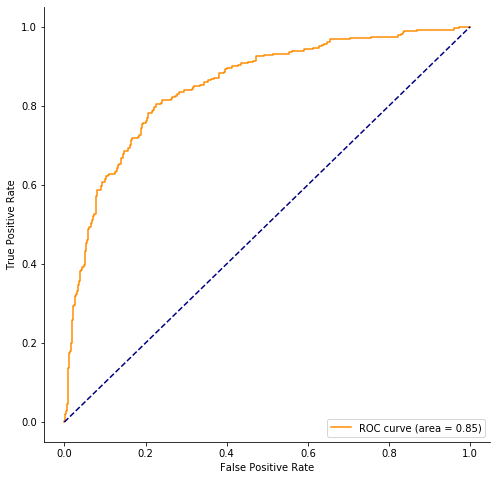

In [23]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("model.h5")

# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy',
                     optimizer=Adam(lr=0.001),
                     metrics=['accuracy'])
# compute prediction
y_test_pred = loaded_model.predict(X_test)

# Compute micro-average ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test.ravel(), y_test_pred.ravel())
roc_auc = auc(fpr, tpr)

# initialize panel
f, ax = plt.subplots(figsize = (8,8))
# plot
ax.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
ax.plot([0, 1], [0, 1], color='navy', linestyle='--')
# disable top and right axes
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# labels and title
ax.axes.set_xlabel('False Positive Rate')
ax.axes.set_ylabel('True Positive Rate')
ax.legend(loc="lower right");

<center><b>Fig 10: </b>ROC Curve for Shallow VGG Model.</center>

### Confusion Matrix

## Weight Visualization